In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread

import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

/Users/seyfullahakseki/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


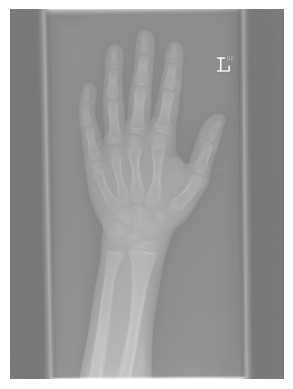

In [2]:
dataframe_dir = "/Users/seyfullahakseki/Desktop/DerinOgrenme/Kemik_Yasi_Tahmini/bonage_dataset"
training_dataframe = pd.read_csv(os.path.join(dataframe_dir, "boneage-training-dataset.csv"))

# doğru yol: iki klasör + .png
training_dataframe["path"] = training_dataframe["id"].map(
    lambda x: os.path.join(dataframe_dir, "boneage-training-dataset", "boneage-training-dataset", f"{x}.png")
)

# diğer işlemler aynı kalabilir
training_dataframe["gender"] = training_dataframe["male"].map(lambda x: "male" if x else "female")
training_dataframe["gender_encoded"] = training_dataframe["gender"].map(lambda x: 1 if x == "male" else 0)
training_dataframe["boneage_category"] = pd.cut(training_dataframe["boneage"], 10)

bonage_std = 2 * training_dataframe["boneage"].std()
bonage_mean = training_dataframe["boneage"].mean()
training_dataframe["norm_age"] = training_dataframe["boneage"].map(lambda x: (x - bonage_mean) / bonage_std)

# Görüntüleme
single_img = training_dataframe["path"].iloc[15]
img = imread(single_img)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
#preprocessing train test split
df_train, df_val= train_test_split(training_dataframe, test_size=0.2, random_state=42,shuffle=True)
valid_df, df_test = train_test_split(df_val, test_size=0.5, random_state=42, shuffle=True)

# Data augmentation
data_augmentation = dict(
    rotation_range=180,
    zoom_range=0.25,
    brightness_range=[0.2, 0.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,
    shear_range=0.05,
    fill_mode='nearest',
    )

train_gen = ImageDataGenerator(
    rescale=1/255,
    preprocessing_function=preprocess_input,
    **data_augmentation
    )
test_val_gen = ImageDataGenerator(
    rescale=1/255,
    preprocessing_function=preprocess_input
    )
img_size = (256, 256)
batch_size = 1
train_data = train_gen.flow_from_dataframe(
    dataframe=df_train,
    x_col="path",
    y_col="boneage",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="other",
    flip_vertical=True,
    color_mode="rgb",
    target_size=img_size,
)

valid_data = test_val_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="path",
    y_col="boneage",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="other",
    flip_vertical=True,
    color_mode="rgb",
    target_size=img_size,
)
test_data = test_val_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col="path",
    y_col="boneage",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="other",
    flip_vertical=True,
    color_mode="rgb",
    target_size=img_size,
)

X_test, y_test = next(test_val_gen.flow_from_dataframe(
    dataframe=df_test,
    x_col="path",
    y_col="boneage",
    batch_size=10*batch_size,
    class_mode="other",
    flip_vertical=True,
    color_mode="rgb",
    target_size=img_size,
    ))

Found 10088 validated image filenames.
Found 1261 validated image filenames.
Found 1262 validated image filenames.
Found 1262 validated image filenames.


In [8]:
#trasfer learning Xception -> fine-tuning
model =tf.keras.applications.xception.Xception(input_shape=(256, 256, 3), 
                                               include_top=False, 
                                               weights='imagenet'
                                               )
model.trainable = True
new_model = Sequential()
new_model.add(model)
new_model.add(GlobalMaxPooling2D())
new_model.add(Flatten())
new_model.add(Dense(10, activation='relu'))
new_model.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
history = new_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=2,
    batch_size=batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/2
  133/10088 ━━━━━━━━━━━━━━━━━━━━ 34:52 210ms/step - loss: 5575.9497 - mae: 57.3321

KeyboardInterrupt: 

In [44]:
#trasfer learning Xception -> fine-tuning
model =tf.keras.applications.xception.Xception(input_shape=(256, 256, 3), 
                                               include_top=False, 
                                               weights='imagenet'
                                               )
model.trainable = True
new_model = Sequential()
new_model.add(model)
new_model.add(GlobalMaxPooling2D())
new_model.add(Flatten())
new_model.add(Dense(10, activation='relu'))
new_model.add(Dense(1, activation='linear'))

opt = Adam(learning_rate=0.001)
new_model.compile(optimizer=opt, loss='mse', metrics=['mae'])
history = new_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=2,
    batch_size=batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/2


2025-06-30 11:27:37.948777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


316/316 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - loss: 1717.8561 - mae: 28.2405 - val_loss: 3660.8145 - val_mae: 40.5144
Epoch 2/2
316/316 ━━━━━━━━━━━━━━━━━━━━ 631s 2s/step - loss: 417.8131 - mae: 16.3085 - val_loss: 1966.2065 - val_mae: 40.4663


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 675ms/step


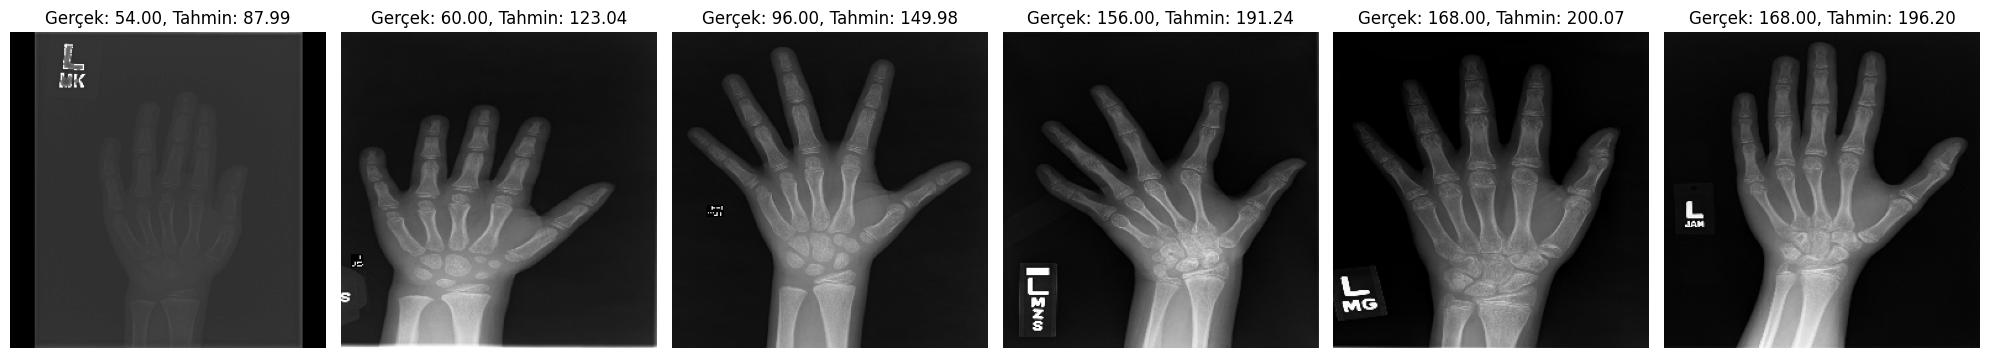

In [48]:
#model evaluation
y_pred = new_model.predict(X_test, batch_size=64,verbose=1)
ord_=np.argsort(y_test)
ord_ = np.array([1,45,67,89,91,109])

fig, ax = plt.subplots(1, 6, figsize=(20, 20))
for (i,ax) in zip(ord_, ax.flatten()):
   ax.imshow(X_test[i,:,:,0],cmap='gray')
   ax.set_title(f"Gerçek: {y_test[i]:.2f}, Tahmin: {y_pred[i][0]:.2f}")
   ax.axis('off')
plt.tight_layout()
plt.show()